# Imports

In [1]:
# Standard library imports
from datetime import datetime
import json
import logging as log
import os
import requests
import sys

# Third party imports
import pandas as pd

# Local application imports
try:
    sys.path.insert(1, os.path.join(os.getcwd(), '../'))
    from scrap_figshare import read_input_file, search_figshare_with_query
    from scrap_figshare import extract_records, request_figshare_dataset_with_id
    from scrap_figshare import main_scrap_figshare
    
    from analyze import prep_analyze, read_df
    from analyze import prepare_timeline_df, plot_timeline_dataset_files, plot_timeline_dataset_authors
    from analyze import prepare_ext_count_df, plot_timeline_category, plot_timeline_engine, plot_timeline_size_engine, plot_extension_engine
    from analyze import get_info_from_mdp, plot_temp_count
    from analyze import get_info_from_gro, plot_sys_size_count
    
except (ModuleNotFoundError, ImportError) as e:
    print(f"{type(e)} fileure: {e}")
else:
    print("Import succeeded")


Import succeeded


# Functions

In [2]:
class AttrDict(dict):
    """Argument parser.

    This function parses a dictionary into a argparse-like dictionary.

    Returns
    -------
    argparse dictionary
    """
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

# FigShare fetching and analysis

## Fetch content

In [3]:
%%time
# Make input parameter
args = AttrDict()
args.update({'input_file': os.path.join(os.getcwd(), '../query.yml')}) #query_dev.yml
# Read parameter file
datasets_df, files_df = main_scrap_figshare(args)
datasets_df

Reading parameters from: /Users/kxp752/repos/mdws/notebooks/../query.yml
Looking for filetype: tpr
Number of datasets found: 23
Number of files found: 958
------------------------------
Looking for filetype: gro
Number of datasets found: 17
Number of files found: 267
------------------------------
Looking for filetype: mdp
Additional keywords for query: molecular dynamics, molecular dynamic, molecular-dynamics, molecular-dynamic, namd, md trajectory, md trajectories, md simulation, md simulations, amber, gromacs, charmm, plumed
Number of datasets found: 7
Number of files found: 28
------------------------------
Looking for filetype: itp
Additional keywords for query: molecular dynamics, molecular dynamic, molecular-dynamics, molecular-dynamic, namd, md trajectory, md trajectories, md simulation, md simulations, amber, gromacs, charmm, plumed
Number of datasets found: 4
Number of files found: 8
------------------------------
Looking for filetype: ndx
Number of datasets found: 0
Number o

,dataset_id,origin,doi,date_creation,date_last_modified,date_fetched,file_number,download_number,view_number,license,title,author,keywords,dataset_url
0,7012004,figshare,10.6084/m9.figshare.7012004.v7,2018-08-30,2018-08-30,2022-01-04T15:38:56,33,208,184,CC BY 4.0,a-Synuclein MD simulations:homo-(A53T+S87N),Hiroki Otaki,Molecular dynamics simulation,https://api.figshare.com/v2/articles/7012004
1,4595473,figshare,10.6084/m9.figshare.4595473.v3,2018-11-15,2018-11-15,2022-01-04T15:38:57,33,1789,738,CC BY 4.0,MD Simulations of Lipid A Phosphoethanol Trans...,Karmen Condic-Jurkic,lipid A phosphoethanolamine transferase ; Neis...,https://api.figshare.com/v2/articles/4595473
2,7010930,figshare,10.6084/m9.figshare.7010930.v1,2018-08-25,2018-08-25,2022-01-04T15:38:58,77,365,119,CC BY 4.0,a-Synuclein short MD simulations:A53T[A-F],Hiroki Otaki,Molecular dynamics simulation,https://api.figshare.com/v2/articles/7010930
3,7011014,figshare,10.6084/m9.figshare.7011014.v8,2018-08-27,2018-08-27,2022-01-04T15:38:59,47,481,225,CC BY 4.0,a-Synuclein MD simulations:WT,Hiroki Otaki,Molecular dynamics simulation,https://api.figshare.com/v2/articles/7011014
4,8046437,figshare,10.6084/m9.figshare.8046437.v1,2019-04-26,2019-04-26,2022-01-04T15:39:00,2,154,137,CC BY 4.0,Short molecular dynamics of a peptide inside a...,davide cruz,MDAnalysis software package ; membrane bilayer...,https://api.figshare.com/v2/articles/8046437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,12713471,figshare,10.4121/uuid:b54162ae-1b09-450b-a258-535d78040b60,2013-06-30,2020-07-28,2022-01-04T17:55:34,1,34,189,4TU General Terms of Use,Experimental research on dynamic dredge overfl...,E.M.M. van Eekelen,dredging ; dynamic plume ; environmental impac...,https://api.figshare.com/v2/articles/12713471
1762,1403409,figshare,10.1371/journal.pone.0125040,2015-05-04,2016-10-31,2022-01-04T17:55:35,10,291,352,CC BY 4.0,Morphologic and Aerodynamic Considerations Reg...,Vincent Casseau,parachute ; permeability ; simulation ; flow r...,https://api.figshare.com/v2/articles/1403409
1763,12708386,figshare,10.4121/uuid:997cc9d8-2281-453e-b631-5f93cfebe00e,2019-07-30,2020-07-28,2022-01-04T17:55:36,1,95,362,CC0,Vapor Plumes Video at La Selva Biological Station,Cesar Dionisio Jimenez-Rodriguez,Vapor Plumes ; dissertation,https://api.figshare.com/v2/articles/12708386
1764,14001149,figshare,10.6084/m9.figshare.14001149.v2,2021-05-14,2021-05-14,2022-01-04T17:55:37,1,13,105,Apache 2.0,Global Survey of Electron Precipitation due to...,Qianli Ma,Hiss Waves ; Electron precipitation ; Van Alle...,https://api.figshare.com/v2/articles/14001149


## Analysis & plots

### Reading

In [4]:
# read dataframe from datasets and files
dataset_tsv = "figshare_datasets.tsv"
files_tsv = "figshare_files.tsv"
args = AttrDict()
args.update({'input_dataset_file': os.path.join(os.getcwd(), dataset_tsv), 
             'input_files_file': os.path.join(os.getcwd(), files_tsv),
            })
# Call extract main prep function
datasets_df, files_df, all_df = prep_analyze(args)

Number of files: 4244
Number of datasets: 1766
Number of files after cleaning: 4244
Number of datasets: 1766


### Plotting dataset statistics (timeline and counts)

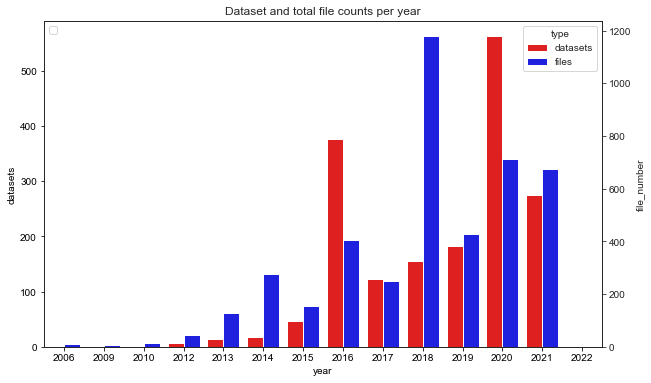

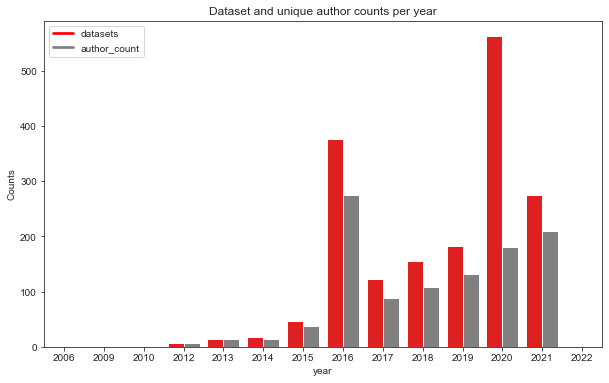

In [5]:
# timeline plot
timeline_ana_df = prepare_timeline_df(datasets_df)
plot_timeline_dataset_files(timeline_ana_df)
plot_timeline_dataset_authors(timeline_ana_df)



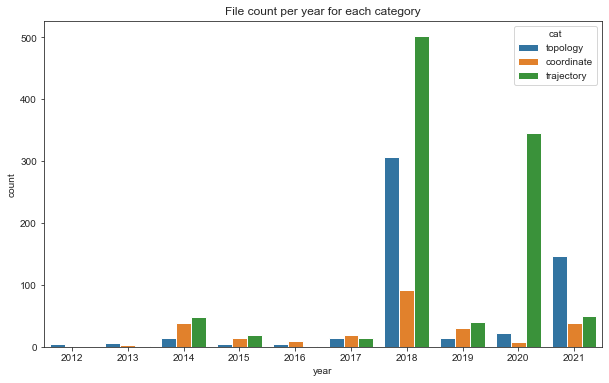

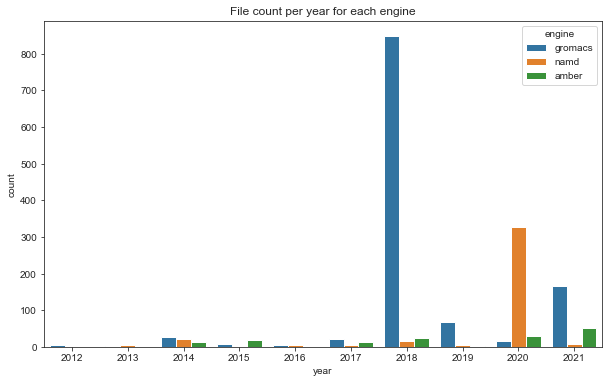

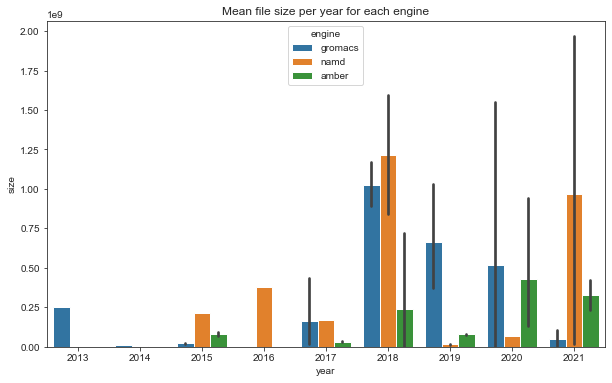

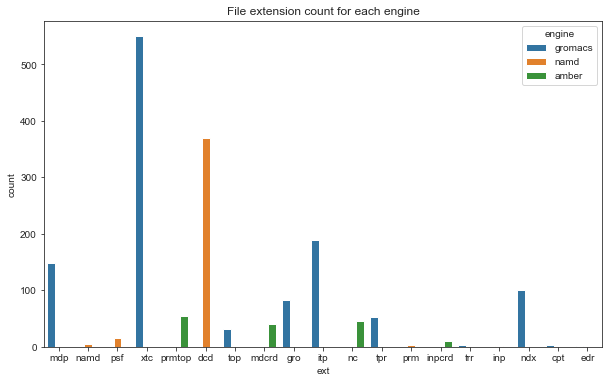

In [6]:
# plot file-dependent timeline plots
count_article_df = prepare_ext_count_df(all_df)
plot_timeline_category(count_article_df)
plot_timeline_engine(count_article_df)
plot_timeline_size_engine(count_article_df)
plot_extension_engine(count_article_df)

In [11]:
# filesize
print(f"Total file size: {files_df['file_size'].sum()/10**12:.1f} TB, {len(files_df)} files")
print(f"Total file size (excl. zip): {files_df.loc[files_df['file_type']!='zip', 'file_size'].sum()/10**12:.1f} TB, {len(files_df.loc[files_df['file_type']!='zip'])} files")

Total file size: 0.8 TB, 4244 files
Total file size (excl. zip): 0.6 TB, 2718 files


### Plotting information grapped from file content (e.g. temperature from mdp & filesize from gro)

Number of mdp files: 149


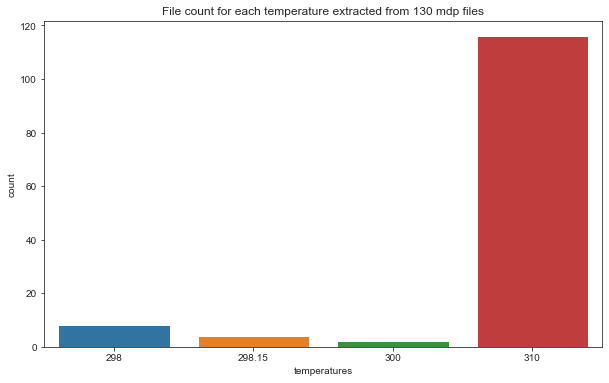

CPU times: user 5.33 s, sys: 622 ms, total: 5.95 s
Wall time: 1min 50s


In [12]:
%%time
# get mdp information
temp_df = get_info_from_mdp(all_df)
# plot mdp information
plot_temp_count(temp_df)


In [ ]:
%%time
# get mdp information
sys_size_df = get_info_from_gro(all_df)
# plot information
plot_sys_size_count(sys_size_df)


Number of gro files: 82
ERROR for dataset ID: 7795913, file name: comp1_oct.gro
